# Data Loading

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import gdown
import zipfile
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
gdown.download('https://drive.google.com/uc?export=download&id=1TUboc7Hyfjfr4lj-jMwRcYwDQd_EHKLD', 'images.zip', quiet=False)

Downloading...
From: https://drive.google.com/uc?export=download&id=1TUboc7Hyfjfr4lj-jMwRcYwDQd_EHKLD
To: /content/images.zip
100%|██████████| 1.35G/1.35G [00:07<00:00, 180MB/s]


'images.zip'

In [ ]:
with zipfile.ZipFile('images.zip', mode='r') as zip_file:
    for zf in tqdm(zip_file.infolist(), desc="Extracting"):
        try:
            zip_file.extract(zf)                
        except Exception as e:
            print(e)
zip_file.close()

Extracting: 100%|██████████| 2571/2571 [00:28<00:00, 90.40it/s] 


# Preprocessing Data

In [ ]:
import os
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Split Data

In [ ]:
def split_data(data, train_size=0.8, random_seed=42):

    """Fungsi ini untuk memisahkan data menjadi train set dan validation_set
    dengan urutan hasil return : data_train, data_validasi"""
    np.random.seed(int(random_seed))
    test_size=1-train_size
    panjang_train = int(train_size*len(data))
    panjang_val = int(test_size*len(data))
    selisih =len(data) - (panjang_train + panjang_val)
    # print(len(data), " - ( ",panjang_train, " + ", panjang_val," ) = ",selisih)
    if selisih > 0:
        panjang_train +=selisih
    
    data_train = []
    #memilih data train dari data
    while len(data_train) != panjang_train:
        bantu = np.random.randint(0, (len(data)-1))
        if data[bantu] not in data_train:
            data_train.append(data[bantu])
            del data[bantu]
     
    #Sisanya Dicopy kedalam Train
    data_validasi = data.copy()
    del data
     
    print("\nPanjang train : ",panjang_train)
    print("Panjang validasi : ",panjang_val,"\n")
    return data_train, data_validasi

In [ ]:
#Selanjutnya pindahkan ke folder terpisah

#Membuat fungsi untuk membuat folder penyimpanan dan memindahkan data yang telah dipisahkan kedalam folder tersebut
def move(data_train, data_val, data_path, train_path, val_path):
    """Fungsi ini untuk membuat folder penyimpanan dan 
    memasukan data yang telah dipisahkan dengan folder tersebut"""
    
    #Memeriksa apakan folder sudah ada, jika belum maka tambahkan folder
    if not (os.path.exists(train_path) and os.path.exists(val_path)):
        os.makedirs(train_path)
        os.makedirs(val_path)
    else:
        print('Folder Sudah ada')
    
    #memindahkan ke folder terpisah
    for i in range(len(data_train)):
        shutil.move(os.path.join(data_path, data_train[i]), os.path.join(train_path, data_train[i]))
    
    #memindahkan ke folder terpisah
    for i in range(len(data_val)):
        shutil.move(os.path.join(data_path, data_val[i]), os.path.join(val_path, data_val[i]))

In [ ]:
def split_and_move_data(path='', random_seed=42, train_size=0.8):
    path_dict = {}
    for i in os.listdir(path):
        path_dict[i] = os.listdir(os.path.join(path, i))
        print(i, "=> sebanyak ", len(os.listdir(os.path.join(path, i))))
      
    dict_train_test = {}
    for cls in path_dict.keys():
        dict_train_test[cls] = split_data(path_dict[cls],random_seed=random_seed,train_size=train_size)
     
    for cls in path_dict.keys():
        move(
           data_train =  dict_train_test[cls][0],
           data_val = dict_train_test[cls][1],
           data_path = os.path.join(path, cls),
           train_path = os.path.join(os.path.join(path,'train'),cls),
           val_path = os.path.join(os.path.join(path,'test'),cls)
        )
        shutil.rmtree(os.path.join(path, cls))
    len_train = 0
    len_test = 0
    train = os.path.join(path,'train')
    test = os.path.join(path,'test')
    for cls in os.listdir(train):
        len_train += len(os.listdir((os.path.join(train,cls))))
        len_test += len(os.listdir((os.path.join(test,cls))))
         
     
    print('train : {} data'.format(len_train))
    print('test  : {} data'.format(len_test))      

In [ ]:
split_and_move_data('Dataset Fix/', train_size=0.9)

dadar_gulung => sebanyak  305
kue_pukis => sebanyak  304
cucur => sebanyak  240
bika_ambon => sebanyak  238
kue_sus => sebanyak  197
kue_lupis => sebanyak  250
onde_onde => sebanyak  280
klepon => sebanyak  237
putu_ayu => sebanyak  271
kue_cubit => sebanyak  238

Panjang train :  275
Panjang validasi :  30 


Panjang train :  274
Panjang validasi :  30 


Panjang train :  217
Panjang validasi :  23 


Panjang train :  215
Panjang validasi :  23 


Panjang train :  178
Panjang validasi :  19 


Panjang train :  226
Panjang validasi :  24 


Panjang train :  253
Panjang validasi :  27 


Panjang train :  214
Panjang validasi :  23 


Panjang train :  244
Panjang validasi :  27 


Panjang train :  215
Panjang validasi :  23 

train : 2311 data
test  : 249 data


# Data Generator

In [ ]:
train_dir = 'Dataset Fix/train'
test_dir = 'Dataset Fix/test'

train_datagen = ImageDataGenerator(
                      rescale=1./255,
                      rotation_range=45,
                      brightness_range=[0.6, 1.5],
                      horizontal_flip=True,
                      fill_mode='wrap',
)

test_datagen = ImageDataGenerator(
                  rescale=1./255
)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=True
)


test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

Found 2311 images belonging to 10 classes.
Found 249 images belonging to 10 classes.


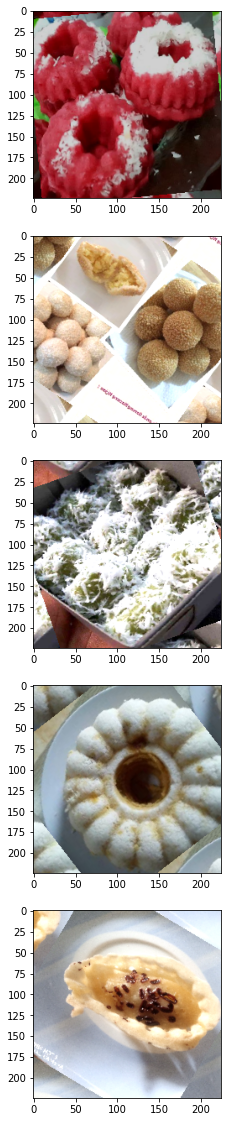

In [ ]:
image, label = next(train_generator)
figs, axes = plt.subplots(5,1, figsize=(20,20))
for idx in range(5):
    axes[idx].imshow(image[idx,:,:,:])
plt.show()

In [ ]:
from tensorflow.keras.applications import mobilenet_v2

In [ ]:
mobilenet = mobilenet_v2.MobileNetV2(weights='imagenet')

14548992/14536120 [==============================] - 0s 0us/step


In [ ]:
# inputs = mobilenet.input
# outputs = mobilenet.layers[-2].outputs
# feature_extractor = Model(inputs=inputs, outputs=outputs)
# model.summary

In [ ]:
from tensorflow.keras import Input, Model, Sequential
from tensorflow.keras.regularizers import l2, l1_l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [ ]:
def get_feature_extractor(model, summary=False):
    inputs = mobilenet.input
    outputs = mobilenet.layers[-2].output
    feature_extractor = Model(inputs=inputs, outputs=outputs)
    if summary:
        feature_extractor.summary()
    return feature_extractor

In [ ]:
get_feature_extractor(mobilenet, True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [ ]:
def custom_mobilenet(feature_extractor):
    model = Sequential([
            feature_extractor,
            Dense(1024, activation=LeakyReLU(0.5), kernel_regularizer=l2(0.001), kernel_initializer='he_normal'),
            Dropout(0.5),
            BatchNormalization(),
            Dense(1024, activation=LeakyReLU(0.5), kernel_regularizer=l2(0.001), kernel_initializer='he_normal'),
            Dropout(0.5),
            BatchNormalization(),
            Dense(10, activation='softmax')
    ])

    return model

In [ ]:
model = custom_mobilenet(get_feature_extractor(mobilenet))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                        

In [ ]:
# def custom_mobilenet(mobilenet):
#     inputs = mobilenet.input
#     feature_extractor = mobilenet.layers[-2].output
#     dense_1 = Dense(32, activation='relu', kernel_regularizer=l2(0.001))(feature_extractor)
#     dropout_1 = Dropout(0.2)(dense_1)
#     dense_2 = Dense(16, activation='relu', kernel_regularizer=l2(0.001))(dropout_1)
#     outputs = Dense(10, activation='softmax')(dense_2)
#     model = Model(inputs=inputs, outputs=outputs)
#     return model

In [ ]:
# model = custom_mobilenet(mobilenet)
# model.summary()

In [ ]:
model.layers[0].trainable = False
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
def checkpoint(filepath, monitor='val_loss'):
    return ModelCheckpoint(filepath=filepath, monitor=monitor, verbose=1, save_best_only=True)

In [ ]:
model_checkpoint = checkpoint('/content/drive/MyDrive/Orbit_final_project/bestmodel', monitor='val_accuracy')
learningrate_decay = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,
                                       patience=10, verbose=1, min_lr=1e-6)
earlystopping = EarlyStopping(monitor='val_accuracy', patience=20, verbose=1)
train_steps_per_epoch = train_generator.n // train_generator.batch_size
val_steps = test_generator.n // test_generator.batch_size
print(train_steps_per_epoch, val_steps) 

36 3


# Transfer Learning

In [ ]:
history = model.fit(train_generator, validation_data=test_generator, epochs=100,
          verbose=1, callbacks=[model_checkpoint, learningrate_decay, earlystopping],
          steps_per_epoch=train_steps_per_epoch, validation_steps=val_steps)

Epoch 1/100
36/36 [==============================] - ETA: 0s - loss: 8.6676 - accuracy: 0.6533
Epoch 00001: val_accuracy improved from -inf to 0.71354, saving model to /content/drive/MyDrive/Orbit_final_project/bestmodel


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestmodel/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestmodel/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


36/36 [==============================] - 159s 4s/step - loss: 8.6676 - accuracy: 0.6533 - val_loss: 12.4946 - val_accuracy: 0.7135 - lr: 0.0100


/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 2/100
36/36 [==============================] - ETA: 0s - loss: 7.9465 - accuracy: 0.7623
Epoch 00002: val_accuracy improved from 0.71354 to 0.81771, saving model to /content/drive/MyDrive/Orbit_final_project/bestmodel


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestmodel/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestmodel/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


36/36 [==============================] - 138s 4s/step - loss: 7.9465 - accuracy: 0.7623 - val_loss: 7.2696 - val_accuracy: 0.8177 - lr: 0.0100


/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 3/100
36/36 [==============================] - ETA: 0s - loss: 5.9955 - accuracy: 0.7810
Epoch 00003: val_accuracy did not improve from 0.81771
36/36 [==============================] - 105s 3s/step - loss: 5.9955 - accuracy: 0.7810 - val_loss: 6.4972 - val_accuracy: 0.6615 - lr: 0.0100
Epoch 4/100
36/36 [==============================] - ETA: 0s - loss: 6.0208 - accuracy: 0.7721
Epoch 00004: val_accuracy did not improve from 0.81771
36/36 [==============================] - 107s 3s/step - loss: 6.0208 - accuracy: 0.7721 - val_loss: 5.9742 - val_accuracy: 0.7760 - lr: 0.0100
Epoch 5/100
36/36 [==============================] - ETA: 0s - loss: 5.2841 - accuracy: 0.7931
Epoch 00005: val_accuracy did not improve from 0.81771
36/36 [==============================] - 106s 3s/step - loss: 5.2841 - accuracy: 0.7931 - val_loss: 5.4393 - val_accuracy: 0.7396 - lr: 0.0100
Epoch 6/100
35/36 [============================>.] - ETA: 2s - loss: 5.4664 - accuracy: 0.7719
Epoch 00006: val_accuracy 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestmodel/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestmodel/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


36/36 [==============================] - 138s 4s/step - loss: 5.4652 - accuracy: 0.7717 - val_loss: 4.5849 - val_accuracy: 0.8594 - lr: 0.0100


/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 7/100
36/36 [==============================] - ETA: 0s - loss: 4.7340 - accuracy: 0.7842
Epoch 00007: val_accuracy did not improve from 0.85938
36/36 [==============================] - 105s 3s/step - loss: 4.7340 - accuracy: 0.7842 - val_loss: 4.6331 - val_accuracy: 0.7604 - lr: 0.0100
Epoch 8/100
36/36 [==============================] - ETA: 0s - loss: 4.6020 - accuracy: 0.7904
Epoch 00008: val_accuracy did not improve from 0.85938
36/36 [==============================] - 105s 3s/step - loss: 4.6020 - accuracy: 0.7904 - val_loss: 4.3204 - val_accuracy: 0.8281 - lr: 0.0100
Epoch 9/100
36/36 [==============================] - ETA: 0s - loss: 4.3656 - accuracy: 0.7917
Epoch 00009: val_accuracy did not improve from 0.85938
36/36 [==============================] - 105s 3s/step - loss: 4.3656 - accuracy: 0.7917 - val_loss: 4.1616 - val_accuracy: 0.7917 - lr: 0.0100
Epoch 10/100
36/36 [==============================] - ETA: 0s - loss: 3.9534 - accuracy: 0.8006
Epoch 00010: val_accuracy

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestmodel/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestmodel/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


36/36 [==============================] - 139s 4s/step - loss: 1.9881 - accuracy: 0.8594 - val_loss: 1.9671 - val_accuracy: 0.8698 - lr: 0.0050
Epoch 19/100
36/36 [==============================] - ETA: 0s - loss: 1.8355 - accuracy: 0.8460
Epoch 00019: val_accuracy did not improve from 0.86979
36/36 [==============================] - 107s 3s/step - loss: 1.8355 - accuracy: 0.8460 - val_loss: 2.0130 - val_accuracy: 0.7604 - lr: 0.0050
Epoch 20/100
35/36 [============================>.] - ETA: 2s - loss: 2.0911 - accuracy: 0.8491
Epoch 00020: val_accuracy did not improve from 0.86979
36/36 [==============================] - 105s 3s/step - loss: 2.0941 - accuracy: 0.8478 - val_loss: 2.1506 - val_accuracy: 0.7917 - lr: 0.0050
Epoch 21/100
36/36 [==============================] - ETA: 0s - loss: 2.3988 - accuracy: 0.8300
Epoch 00021: val_accuracy did not improve from 0.86979
36/36 [==============================] - 104s 3s/step - loss: 2.3988 - accuracy: 0.8300 - val_loss: 2.3834 - val_accur

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestmodel/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestmodel/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


36/36 [==============================] - 136s 4s/step - loss: 2.2623 - accuracy: 0.8215 - val_loss: 2.2807 - val_accuracy: 0.8854 - lr: 0.0050
Epoch 25/100
36/36 [==============================] - ETA: 0s - loss: 2.3164 - accuracy: 0.8367
Epoch 00025: val_accuracy did not improve from 0.88542
36/36 [==============================] - 104s 3s/step - loss: 2.3164 - accuracy: 0.8367 - val_loss: 2.2567 - val_accuracy: 0.8490 - lr: 0.0050
Epoch 26/100
36/36 [==============================] - ETA: 0s - loss: 2.0876 - accuracy: 0.8469
Epoch 00026: val_accuracy did not improve from 0.88542
36/36 [==============================] - 106s 3s/step - loss: 2.0876 - accuracy: 0.8469 - val_loss: 2.2683 - val_accuracy: 0.8125 - lr: 0.0050
Epoch 27/100
36/36 [==============================] - ETA: 0s - loss: 1.9526 - accuracy: 0.8402
Epoch 00027: val_accuracy did not improve from 0.88542
36/36 [==============================] - 105s 3s/step - loss: 1.9526 - accuracy: 0.8402 - val_loss: 1.7643 - val_accur

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestmodel/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestmodel/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


36/36 [==============================] - 134s 4s/step - loss: 1.9161 - accuracy: 0.8709 - val_loss: 1.7222 - val_accuracy: 0.8906 - lr: 0.0050
Epoch 33/100
36/36 [==============================] - ETA: 0s - loss: 1.7218 - accuracy: 0.8496
Epoch 00033: val_accuracy did not improve from 0.89062
36/36 [==============================] - 106s 3s/step - loss: 1.7218 - accuracy: 0.8496 - val_loss: 1.8760 - val_accuracy: 0.8646 - lr: 0.0050
Epoch 34/100
36/36 [==============================] - ETA: 0s - loss: 1.7893 - accuracy: 0.8647
Epoch 00034: val_accuracy did not improve from 0.89062
36/36 [==============================] - 106s 3s/step - loss: 1.7893 - accuracy: 0.8647 - val_loss: 1.8185 - val_accuracy: 0.8490 - lr: 0.0050
Epoch 35/100
36/36 [==============================] - ETA: 0s - loss: 2.0286 - accuracy: 0.8331
Epoch 00035: val_accuracy did not improve from 0.89062
36/36 [==============================] - 105s 3s/step - loss: 2.0286 - accuracy: 0.8331 - val_loss: 2.3377 - val_accur

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestmodel/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestmodel/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


36/36 [==============================] - 132s 4s/step - loss: 1.4353 - accuracy: 0.8856 - val_loss: 1.3292 - val_accuracy: 0.9062 - lr: 0.0025
Epoch 51/100
36/36 [==============================] - ETA: 0s - loss: 1.3338 - accuracy: 0.8883
Epoch 00051: val_accuracy did not improve from 0.90625
36/36 [==============================] - 102s 3s/step - loss: 1.3338 - accuracy: 0.8883 - val_loss: 1.3082 - val_accuracy: 0.8958 - lr: 0.0025


In [ ]:
plt.figure(figsize=(20,9))
plt.subplot(121)
plt.title('grafik loss')
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()

plt.subplot(122)
plt.title('grafik accuracy')
plt.plot(history.history['accuracy'], label='training')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.show()